In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from vowpalwabbit.sklearn_vw import VWClassifier, VW
import itertools

from hyperopt.mongoexp import MongoTrials

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack

In [4]:
def load_data(pkl_path="", csv_path=""):
    if pkl_path != "":
        pkl_file = open(pkl_path, 'rb')
        data = pickle.load(pkl_file)
    elif csv_path != "":
        data = pd.read_csv(csv_path)
    return data    

In [5]:
def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

In [6]:
def site_times_to_sparse(sitetimes):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse

In [7]:
def create_site_user_dic(train_data, site_freq_file):
    user_dic = {}
    site_dic = {}

    pkl_file = open(site_freq_file, 'rb')
    site_freq = pickle.load(pkl_file)
    top_sites = [v[1] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:0]]

    for i, v in train_data.iterrows():
        if v.target not in user_dic:
            user_dic[v.target] = {}
        for site in ['site' + str(i) for i in range(1,11)]:
            if v[site] != 0 and v[site] not in top_sites:
                if v[site] in user_dic[v.target]:
                    user_dic[v.target][v[site]] +=1
                else:
                    user_dic[v.target][v[site]] = 1

            if v[site] in site_dic:
                site_dic[v[site]].add(v.target)
            else:
                site_dic[v[site]] = set([v.target])
    
    return [user_dic, site_dic]

In [8]:
def add_predictions(train_data, test_data, site_dic, user_dic, num_users = 1, dict_pred=True):
    dict_pred = {}
    for data in [train_data, test_data]:
        if not dict_pred:
            data["prediction"] = 0
        for r, v in data.iterrows():
            session_prediction = []
            for site in ['site' + str(c) for c in range(1,11)]:
                if v[site] in site_dic and len(site_dic[v[site]]) == 1:
                    data.set_value(r, -1, list(site_dic[v[site]])[0], takeable=True)
                    continue
                elif v[site] in site_dic and len(site_dic[v[site]]) < num_users:
                    predictions = sorted([[int(user), float(user_dic[user][v[site]]) / sum(user_dic[user].values())] \
                                         for user in site_dic[v[site]] if v[site] in user_dic[user]], \
                                                                       key=lambda t: t[1], reverse=True)
                    if len(predictions):
                        session_prediction.append(predictions[0])
                        
            if len(session_prediction):
                if not dict_pred:
                    if v["prediction"] == 0:
                        prediction = sorted(session_prediction, key=lambda t: t[1], reverse=True)[0][0]
                        data.set_value(r, -1, prediction, takeable=True)
                else:
                    prediction = sorted(session_prediction, key=lambda t: t[1], reverse=True)[0]
                    dict_pred[r] = {prediction[0]: prediction[1]}
    if not dict_pred:
        return [train_data, test_data]
    else:
        dict_pred

In [9]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]

In [10]:
def sites_to_sparse(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,session_length+1)]].fillna(0).astype('int')
    X_train_test_sites_sparse = sparsematrix(train_test_df_sites.as_matrix())
    X_train_sites_sparse = X_train_test_sites_sparse[:len(train_data)]
    X_test_sites_sparse = X_train_test_sites_sparse[len(train_data):]
    y = train_data[target_col]
    
    sites_columns_num = X_train_test_sites_sparse.shape[1]
    
    train_test_df_t_sites = train_test_df[['t_site' + str(c) for c in range(1,session_length+1)]].fillna(0).astype('int')
    X_train_test_t_sites_sparse = sparsematrix(train_test_df_t_sites.as_matrix())
    X_train_t_sites_sparse = X_train_test_t_sites_sparse[:len(train_data)]
    X_test_t_sites_sparse = X_train_test_t_sites_sparse[len(train_data):]
    
    t_sites_columns_num = X_train_test_t_sites_sparse.shape[1]
    
    train_test_df_s_sites = train_test_df[['s_site' + str(c) for c in range(1,session_length+1)]].fillna(0).astype('int')
    X_train_test_s_sites_sparse = sparsematrix(train_test_df_s_sites.as_matrix())
    X_train_s_sites_sparse = X_train_test_s_sites_sparse[:len(train_data)]
    X_test_s_sites_sparse = X_train_test_s_sites_sparse[len(train_data):]
    
    s_sites_columns_num = X_train_test_s_sites_sparse.shape[1]
    
    
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sites_sparse, X_test_sites_sparse, \
            X_train_t_sites_sparse, X_test_t_sites_sparse, \
            X_train_s_sites_sparse, X_test_s_sites_sparse, \
            y, y_for_vw, sites_columns_num, t_sites_columns_num, s_sites_columns_num, class_encoder]

In [11]:
def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix

In [12]:
def combine_sites_features_sparse(X_train_sites_sparse, X_train_t_sites_sparse, \
                                  X_train_s_sites_sparse, train_features, \
                                  X_test_sites_sparse, X_test_t_sites_sparse, \
                                  X_test_s_sites_sparse, test_features, \
                                  train_site_times_sparse = None, test_site_times_sparse = None):
    if train_site_times_sparse is not None and test_site_times_sparse is not None:
        X_train_sparse = hstack([X_train_sites_sparse, X_train_t_sites_sparse, \
                                 X_train_s_sites_sparse, train_features, train_site_times_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([X_test_sites_sparse, X_test_t_sites_sparse, \
                                X_test_s_sites_sparse, test_features], dtype=float).tocsr()
    else:
        X_train_sparse = hstack([X_train_sites_sparse, X_train_t_sites_sparse, \
                                 X_train_s_sites_sparse, train_features], dtype=float).tocsr()
        X_test_sparse = hstack([X_test_sites_sparse, X_test_t_sites_sparse, \
                                X_test_s_sites_sparse, test_features, test_site_times_sparse], dtype=float).tocsr()
    return [X_train_sparse, X_test_sparse]

In [13]:
def sparse_matrix_to_vw(X_sparse, sites_columns_num, t_sites_columns_num, s_sites_columns_num, y=None):
    sessions = {}
    t_sites = {}
    s_sites = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("prediction"):
                prediction[r] = " |aprediction {}:{}".format(int(X_sparse[r,c]), 100)
                #prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("day_of_week"):
                day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("start_hour"):
                start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("daytime"):
                daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("session_timespan"):
                session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("#unique_sites"):
                unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("site_longest_time"):
                site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("top30_portion"):
                top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("bot30_portion"):
                bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("fb_portion"):
                fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("youtube_portion"):
                youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                continue
            if c < sites_columns_num: #X_sparse.shape[1] - len(mycolumns): 
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                else:
                    if y is not None:
                        sessions[r] = str(y[r]) + ' |site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                    else:
                        sessions[r] = ' |site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
            elif c >= sites_columns_num and c < sites_columns_num + t_sites_columns_num: #X_sparse.shape[1] - len(mycolumns): 
                if r in t_sites:
                    t_sites[r] += " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                else:
                    t_sites[r] = ' |zt_site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
            elif c >= sites_columns_num + t_sites_columns_num and c < sites_columns_num + t_sites_columns_num + s_sites_columns_num: #X_sparse.shape[1] - len(mycolumns): 
                if r in s_sites:
                    s_sites[r] += " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                else:
                    s_sites[r] = ' |ys_site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
            elif c >= X_sparse.shape[1] - sites_columns_num:
                if r in sitetimes:
                    sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                else:
                    sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "t_sites": t_sites, "s_sites": s_sites, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes}

In [14]:
def vw_to_file(sites, out_file, features={}, quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        final_vw[r] = sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites", "session_timespan"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        
            
        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()

In [15]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Let's check if creating sessions with windows [5, 7] improves accuracy**

In [20]:
# Loading processed train and test files
train_data = load_data(csv_path='kaggle_data/full_train_w8_tssite.csv')
test_data = load_data(csv_path='kaggle_data/full_test_tssite.csv')

In [18]:
%%time
# Additionally, let's calculate the percentage of session time spent by every site in session
site_times = calc_site_times_portions(train_data, test_data)

CPU times: user 45.1 s, sys: 160 ms, total: 45.3 s
Wall time: 45 s


In [19]:
# Convert site times to sparse format
site_times_sparse = site_times_to_sparse(site_times)
train_site_times_sparse = site_times_sparse[:len(train_data)]
test_site_times_sparse = site_times_sparse[len(train_data):]

In [511]:
%%time
#Generate only once per kernel launch
#user_dic, site_dic = create_site_user_dic(train_data, site_freq_file="kaggle_data/site_freq.pkl")

CPU times: user 2min, sys: 420 ms, total: 2min 1s
Wall time: 2min


In [512]:
%%time
#Predictions no longer needed since they are already included in train and test data!
#train_data, test_data = add_predictions(train_data, test_data, site_dic, user_dic, num_users = 1)

CPU times: user 1min 8s, sys: 256 ms, total: 1min 8s
Wall time: 1min 8s


In [75]:
total_filled = len(train_data[train_data.prediction != 0]) / float(len(train_data))
right_filled = sum([int(int(a) == int(b)) for a, b in \
                                    zip(train_data["target"], train_data["prediction"])]) / float(len(train_data))
print "total_filled:", total_filled
print "right_filled", right_filled
print right_filled/total_filled

total_filled: 0.174006937451
right_filled 0.174006937451
1.0


In [36]:
test_data[range(20, 40)]

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,site_longest_time,start_hour,day_of_week,daytime,fb_portion,youtube_portion,top30_portion,bot30_portion,prediction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1917,20,3,2,0.000000,0.000000,0.000000,0.000000,0
1,4.0,0.0,51.0,53.0,1.0,1.0,22.0,1.0,1.0,134.0,6,32,14,1,1,0.000000,0.000000,0.395522,0.223881,783
2,4.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,13.0,5,71,9,0,0,0.000000,0.000000,0.153846,0.000000,0
3,1697.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1740.0,1,7338,13,4,1,0.000000,0.000000,0.000000,0.000000,0
4,8.0,1.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,16.0,7,19622,9,0,0,0.000000,0.000000,0.062500,0.625000,631
5,96.0,1.0,49.0,1.0,2.0,22.0,32.0,2.0,1.0,206.0,3,1940,10,4,0,0.000000,0.000000,0.888350,0.000000,0
6,0.0,6.0,158.0,64.0,23.0,0.0,0.0,0.0,0.0,251.0,6,252,15,3,1,0.000000,0.000000,0.023904,0.000000,0
7,2.0,0.0,40.0,47.0,144.0,480.0,34.0,14.0,65.0,826.0,8,280,14,1,1,0.000000,0.000000,0.720339,0.000000,0
8,7.0,4.0,27.0,1.0,16.0,4.0,8.0,30.0,11.0,108.0,2,1945,11,4,0,0.000000,0.000000,1.000000,0.000000,0
9,0.0,0.0,0.0,2.0,5.0,2.0,1.0,1.0,1.0,12.0,5,680,13,2,1,0.000000,0.000000,0.000000,0.000000,0


In [37]:
%%time
X_train_sites_sparse, X_test_sites_sparse, \
X_train_t_sites_sparse, X_test_t_sites_sparse, \
X_train_s_sites_sparse, X_test_s_sites_sparse, \
y, y_for_vw, sites_columns_num, t_sites_columns_num, s_sites_columns_num, class_encoder = \
    sites_to_sparse(train_data, test_data, "target", 10, label_encoder=LabelEncoder())
    
mycolumns = [label for label in test_data[range(20, 40)]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)

X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_sites_sparse, X_train_t_sites_sparse, \
                                                              X_train_s_sites_sparse, train_features, \
                                                             X_test_sites_sparse, X_test_t_sites_sparse, \
                                                              X_test_s_sites_sparse, test_features, \
                                                              train_site_times_sparse, test_site_times_sparse)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)

Sparse Matrix - rows: 150485 columns: 24053
Sparse Matrix - rows: 150485 columns: 124
Sparse Matrix - rows: 150485 columns: 10122
CPU times: user 6.69 s, sys: 408 ms, total: 7.1 s
Wall time: 6.91 s


In [38]:
len(mycolumns)

20

In [39]:
X_train.shape[1] - sites_columns_num - t_sites_columns_num - s_sites_columns_num - len(mycolumns)

24052

In [40]:
X_train_sparse

<109308x58368 sparse matrix of type '<type 'numpy.float64'>'
	with 3852636 stored elements in Compressed Sparse Row format>

In [49]:
%%time
train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, t_sites_columns_num, s_sites_columns_num, y_train)
valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, t_sites_columns_num, s_sites_columns_num, y_valid)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, t_sites_columns_num, s_sites_columns_num, y_for_vw)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num, t_sites_columns_num, s_sites_columns_num)

CPU times: user 6min 13s, sys: 1.2 s, total: 6min 14s
Wall time: 6min 14s


In [46]:
X_train.shape[0]

76515

In [51]:
for k in train_part_vw.keys():
    print k, len(train_part_vw[k])

youtube_portion 4224
site_longest_time 76515
top30_portion 54070
sitetimes 75870
unique_site 76515
start_hour 76515
prediction 15732
session_timespan 75046
day_of_week 76515
bot30_portion 29093
s_sites 76496
t_sites 76496
fb_portion 9995
sites 76515
daytime 76515


In [52]:
folder = "kaggle_data/"
handler = "_vw_w8_tssites"

In [100]:
%%time
with open(folder+'train_part'+handler+'.pkl', 'wb') as f:
    pickle.dump(train_part_vw, f)
with open(folder+'valid'+handler+'.pkl', 'wb') as f:
    pickle.dump(valid_vw, f)
with open(folder+'train'+handler+'.pkl', 'wb') as f:
    pickle.dump(train_vw, f)
with open(folder+'test'+handler+'.pkl', 'wb') as f:
    pickle.dump(test_vw, f)
with open(folder+'class_encoder'+handler+'.pkl', 'wb') as f:
    pickle.dump(class_encoder, f)
    
y.to_csv(folder+'y'+handler+'.csv', index=False, header=False)
pd.DataFrame(y_train).to_csv(folder+'y_train'+handler+'.csv', index=False, header=False)
pd.DataFrame(y_valid).to_csv(folder+'y_valid'+handler+'.csv', index=False, header=False)

import datetime
print datetime.datetime.now().strftime('Configuration saved on %d, %b %Y - %H:%M')

datetime.datetime(2017, 1, 2, 3, 39, 3, 222575)

In [19]:
%%time
with open(folder+'train_part'+handler+'.pkl', 'rb') as f:
    train_part_vw = pickle.load(f)
with open(folder+'valid'+handler+'.pkl', 'rb') as f:
    valid_vw = pickle.load(f)
with open(folder+'train'+handler+'.pkl', 'rb') as f:
    train_vw = pickle.load(f)
with open(folder+'test'+handler+'.pkl', 'rb') as f:
    test_vw = pickle.load(f)
with open(folder+'class_encoder'+handler+'.pkl', 'rb') as f:
    class_encoder = pickle.load(f)
y=pd.read_csv(folder+'y'+handler+'.csv', header=None, squeeze=True)
y_train=pd.read_csv(folder+'y_train'+handler+'.csv', header=None, squeeze=True)
y_valid=pd.read_csv(folder+'y_valid'+handler+'.csv', header=None, squeeze=True)

CPU times: user 39.2 s, sys: 1.13 s, total: 40.4 s
Wall time: 40.4 s


In [53]:
keys = [
   'day_of_week',
   'daytime',
   'prediction',
   'start_hour',
   'youtube_portion', 'fb_portion', 't_sites', 's_sites']

vw_to_file(train_part_vw["sites"], 'kaggle_data/train_part_vw_w8_tssites.vw', features={x:train_part_vw[x] for x in keys}, quiet=False)
vw_to_file(valid_vw["sites"], 'kaggle_data/valid_vw_w8_tssites.vw', features={x:valid_vw[x] for x in keys}, quiet=False)
vw_to_file(train_vw["sites"], 'kaggle_data/train_vw_w8_tssites.vw', features={x:train_vw[x] for x in keys}, quiet=False)
vw_to_file(test_vw["sites"], 'kaggle_data/test_vw_w8_tssites.vw', features={x:test_vw[x] for x in keys}, quiet=False)


Features: ['youtube_portion', 's_sites', 't_sites', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 's_sites', 't_sites', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 's_sites', 't_sites', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 's_sites', 't_sites', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']


In [54]:
with open("kaggle_data/train_part_w5.vw") as f:
    train_part_file = f.readlines()

with open("kaggle_data/train_w5.vw") as f:
    train_file = f.readlines()

with open("kaggle_data/valid_w5.vw") as f:
    valid_file = f.readlines()

with open("kaggle_data/test_w5.vw") as f:
    test_file = f.readlines()

In [58]:
%%time
!vw --oaa=550 -d kaggle_data/train_part_vw_w8_tssites.vw --passes=20 \
-f kaggle_data/initial_model_vw_w8_tssites.vw -b 27 -c -k \
--decay_learning_rate 0.8097261737051064 \
--initial_t 4.617634843743026e-05 -l 0.3037695975303308 --power_t 0.5 --l2=1e-9 \
--loss_function='logistic' --l1=1.2144958188964683e-10 --cubic="sbc" --sort_features -q "bs" \
--ignore "z" --ignore "y"
#--stage_poly --batch_sz 20007 --batch_sz_no_doubling

creating quadratic features for pairs: bs 
creating cubic features for triples: sbc 
ignoring namespaces beginning with: z y 
using l1 regularization = 1.2145e-10
using l2 regularization = 1e-09
final_regressor = kaggle_data/initial_model_vw_w8_tssites.vw
Num weight bits = 27
learning rate = 0.30377
initial_t = 4.61763e-05
power_t = 0.5
decay_learning_rate = 0.809726
creating cache_file = kaggle_data/train_part_vw_w8_tssites.vw.cache
Reading datafile = kaggle_data/train_part_vw_w8_tssites.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      145        1       33
1.000000 1.000000            2            2.0      412      145       29
1.000000 1.000000            4            4.0      318      412       11
1.000000 1.000000            8            8.0      386      145       23
1.000000 1.000000           16           16.0    

In [47]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [48]:
%%time
model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, decay_learning_rate=0.8097261737051064, \
           initial_t=4.617634843743026e-05, l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, \
           loss_function='logistic', l1=1.2144958188964683e-11, cubic="sbc", sort_features=True, q="sd", noconstant=True)

c_scores = cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=1)
print c_scores, np.mean(c_scores)

KeyboardInterrupt: 

In [146]:
%%time
#model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, loss_function='squared', random_seed=7)
model.fit(train_part_file)
print accuracy_score(y_valid, model.predict(valid_file))

0.533912364595
CPU times: user 12min 30s, sys: 1.66 s, total: 12min 32s
Wall time: 12min 21s


In [546]:
%%time
model.fit(train_file)
test = model.predict(test_file)
submission = pd.DataFrame(test.astype(int)-1)
vw_subm = class_encoder.inverse_transform(submission)
vw_subm

CPU times: user 7min 23s, sys: 1.23 s, total: 7min 25s
Wall time: 7min 19s


In [547]:
print accuracy_score(y_valid, model.predict(valid_file))

0.66049382716


In [548]:
write_to_submission_file(vw_subm,
                         'kaggle_data/10vw_submission.csv')

### Hyperopt

In [ ]:
def run_vw(y_valid, params):
    for param in params:
        if param == "l2":
            l2 = params["l2"]
        elif param == "l1":
            l1 = params["l1"]
        elif param == "decay_learning_rate":
            decay_learning_rate = params["decay_learning_rate"]
        elif param == "initial_t":
            initial_t = params["initial_t"]:
        elif param == "l":
            l = params["l"]
        elif param == "power_t":
            power_t = params["power_t"]
        elif param == "loss_function":
            loss_function = params["loss_function"]
        elif param == "cubic":
            cubic = params["cubic"]
        elif param == "q":
            q = params["q"]
        elif param == ["sort_features"]:
            sort_features = params["sort_features"]
        
    !vw --oaa=550 -d kaggle_data/train_part_w5.vw --passes=30 --quiet \
    -f kaggle_data/initial_model_w5.vw -b 26 -c -k \
    --decay_learning_rate {decay_learning_rate} \
    --initial_t {initial_t} -l {l} --power_t {power_t} --l2={l2} \
    --loss_function={loss_function} --l1={l1} --cubic={cubic} \
    --sort_features={sort_features} -q {q} 
    
    !vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
    -p kaggle_data/vw_valid_pred_w5.csv --random_seed=7 --quiet
    
    vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred_w5.csv", header=None)
    accuracy = accuracy_score(y_valid, vw_valid_pred.values)
    
    return accuracy

In [ ]:
%%time
y = y_train
y_v = y_valid
def hyperopt_train_test(params):
    
    with open("kaggle_data/train_part_w5.vw") as f:
        train_part_file = f.readlines()
        
    with open("kaggle_data/valid_w5.vw") as f:
        valid_file = f.readlines()
    
    skf = StratifiedKFold(n_splits=2, shuffle=True)

    t = params['type']
    del params['type']
    if t == 'polynomial_regression':
        model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, **params)
        return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=-1).mean()
    elif t == 'stage_poly':
        clf = SVC(**params)
    elif t == 'dtree':
        clf = DecisionTreeClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, X, y).mean()

    

space = hp.choice('classifier_type', [
    {
        'type': 'polynomial_regression',
        'l': hp.loguniform('l', -5, 3),
        'initial_t': hp.loguniform('initial_t', -10, 1),
        'power_t': hp.choice('power_t', [0.5, 1]),
        'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
        'l2': hp.uniform('l2', 1e-20, 1e-10),
        'l1': hp.uniform('l1', 1e-20, 1e-10),
        'loss_function': hp.choice('loss_function', ["logistic"]),
        'sort_features': hp.choice('sort_features', [True, False]),
        'ftrl': hp.choice('ftrl', [True, False]),
        'cubic': hp.choice('cubic', ['sbc']),
        'q': hp.choice('q', ["sb", "sc", "sd"])
    },
    {
        'type': 'bfgs',
        
    },
    {    'type': 'neural',
     
    }
])


def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=200, trials=trials)
print 'best:'
print best

#### Single model

In [ ]:
%%time
def hyperopt_train_test(params):
    with open("kaggle_data/train_part_w5.vw") as f:
        train_part_file = f.readlines()
    
    with open("kaggle_data/valid_w5.vw") as f:
        valid_file = f.readlines()
    
    model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, **params)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(train_part_file)
    accuracy = accuracy_score(y_valid, model.predict(valid_file))
    return accuracy
    #return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3).mean()

space4knn = {
    'l': hp.loguniform('l', -5, 3),
    'initial_t': hp.loguniform('initial_t', -10, 1),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
    'l2': hp.loguniform('l2', -20, -9),
    'l1': hp.loguniform('l1', -20, -9),
    'loss_function': hp.choice('loss_function', ["logistic", "hinge", "squared"]),
    'sort_features': hp.choice('sort_features', [True, False]),
    'ftrl': hp.choice('ftrl', [True, False]),
    'noconstant': hp.choice('noconstant', [True, False]),
    'cubic': hp.choice('cubic', ['sbc']),
    'q': hp.choice('q', ["sb", "sc", "sd", "si"])
}

def f(params):
    print "Testing with params:"
    print params
    acc = hyperopt_train_test(params)
    print "Accuracy:", acc, "\n"
    return {'loss': -acc, 'status': STATUS_OK}

trials_wide_range = Trials()
#trials_wide_range = MongoTrials('mongo://localhost:1234/identifyme-db/jobs')
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials_wide_range)
print 'best:'
print best

Testing with params:
{'cubic': 'sbc', 'ftrl': False, 'decay_learning_rate': 0.5264974796272308, 'initial_t': 0.004897759165280285, 'l': 0.24309443596820982, 'q': 'sc', 'power_t': 1, 'noconstant': False, 'l2': 4.660735186193095e-08, 'loss_function': 'squared', 'l1': 2.399357439410996e-07, 'sort_features': False}
Accuracy: 0.535686518426 

Testing with params:
{'cubic': 'sbc', 'ftrl': False, 'decay_learning_rate': 0.0994963186179739, 'initial_t': 1.7937241410153726, 'l': 0.3753597056166588, 'q': 'si', 'power_t': 0.5, 'noconstant': True, 'l2': 3.5076892605494836e-05, 'loss_function': 'squared', 'l1': 5.0180269192424504e-08, 'sort_features': True}
Accuracy: 0.121617944332 

Testing with params:
{'cubic': 'sbc', 'ftrl': False, 'decay_learning_rate': 0.4327803359740513, 'initial_t': 0.0271798390552909, 'l': 3.962908826723026, 'q': 'sd', 'power_t': 0.5, 'noconstant': False, 'l2': 6.648134616070968e-07, 'loss_function': 'logistic', 'l1': 7.547397100882356e-09, 'sort_features': False}
Accuracy:

In [32]:
trials_wide_range.best_trial

{'book_time': datetime.datetime(2017, 1, 3, 22, 39, 36, 763000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'cubic': [18],
   'decay_learning_rate': [18],
   'ftrl': [18],
   'initial_t': [18],
   'l': [18],
   'l1': [18],
   'l2': [18],
   'loss_function': [18],
   'noconstant': [18],
   'power_t': [18],
   'q': [18],
   'sort_features': [18]},
  'tid': 18,
  'vals': {'cubic': [0],
   'decay_learning_rate': [0.268248182714606],
   'ftrl': [1],
   'initial_t': [0.010855850960034852],
   'l': [1.3672853106801708],
   'l1': [1.82581713861064e-08],
   'l2': [2.3074830671449034e-07],
   'loss_function': [2],
   'noconstant': [1],
   'power_t': [0],
   'q': [2],
   'sort_features': [0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2017, 1, 3, 22, 44, 46, 13000),
 'result': {'loss': -0.6755559011040274, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 18,
 'version': 0}

Testing with params:
{'cubic': 'sbc', 'ftrl': False, 'decay_learning_rate': 0.268248182714606, 'initial_t': 0.010855850960034852, 'l': 1.3672853106801708, 'q': 'sd', 'power_t': 0.5, 'noconstant': False, 'l2': 2.3074830671449034e-07, 'loss_function': 'squared', 'l1': 1.82581713861064e-08, 'sort_features': True}
Accuracy: 0.675555901104 

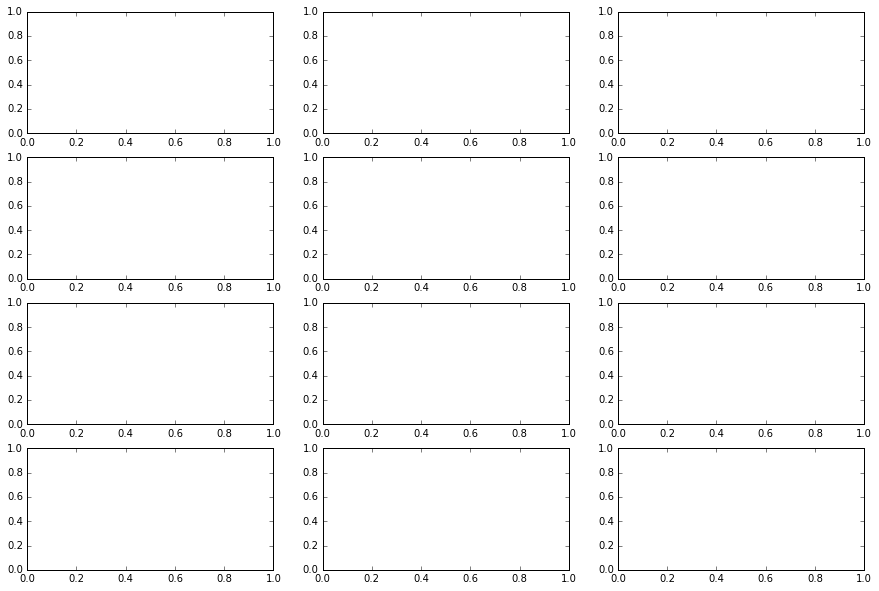

In [35]:
# W5, session sort, with sitetimes, wide search window
parameters = ['l', 'initial_t', 'power_t', 'decay_learning_rate', 'l2', 'l1', 'loss_function', \
              'sort_features', 'ftrl', 'noconstant', 'cubic', 'q']
cols = len(parameters)
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    #print i, val
    if "loss" in t['result']:
        xs = np.array([t['misc']['vals'][val] for t in trials_wide_range.trials]).ravel()
        ys = [-t['result']['loss'] for t in trials_wide_range.trials]
        xs, ys = zip(*sorted(zip(xs, ys)))
        ys = np.array(ys)
        axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
        axes[i/3,i%3].set_title(val)
        #axes[i/3,i%3].set_ylim([0.9,1.0])

In [30]:
#best:
#{'q2': 5, 'cubic': 1, 'decay_learning_rate': 0.7512590918166849, 'initial_t': 0.002337045080352835, 'l': 0.8416950450219994, 'power_t': 0, 'l2': 9.920086846923105e-11, 'loss_function': 0, 'l1': 1.1196285339786284e-12}

trials.best_trial

{'book_time': datetime.datetime(2017, 1, 1, 10, 4, 37, 833000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'cubic': [22],
   'decay_learning_rate': [22],
   'initial_t': [22],
   'l': [22],
   'l1': [22],
   'l2': [22],
   'loss_function': [22],
   'power_t': [22],
   'q2': [22]},
  'tid': 22,
  'vals': {'cubic': [1],
   'decay_learning_rate': [0.7512590918166849],
   'initial_t': [0.002337045080352835],
   'l': [0.8416950450219994],
   'l1': [1.1196285339786284e-12],
   'l2': [9.920086846923105e-11],
   'loss_function': [0],
   'power_t': [0],
   'q2': [5]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2017, 1, 1, 10, 17, 33, 550000),
 'result': {'loss': -0.6502271193631194, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 22,
 'version': 0}

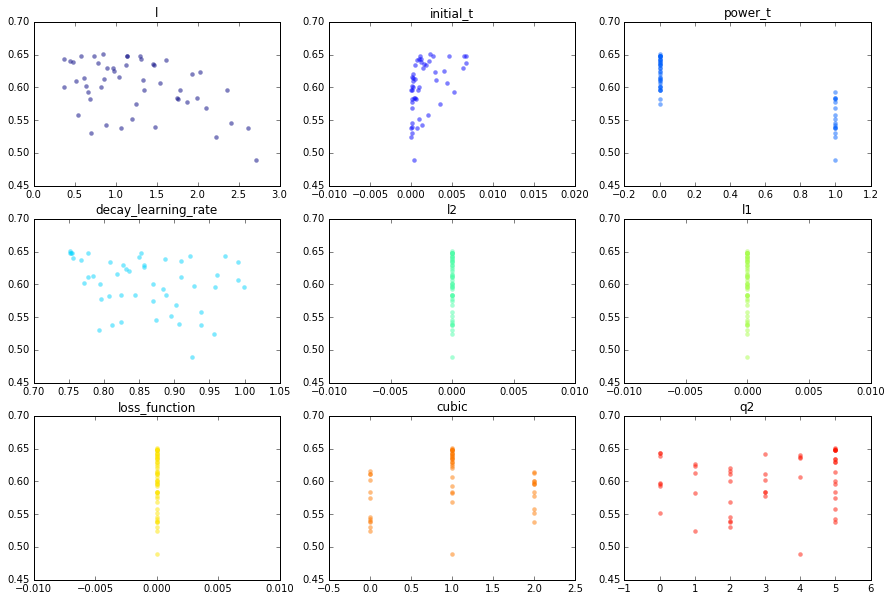

In [27]:
parameters = ['l', 'initial_t', 'power_t', 'decay_learning_rate', 'l2', 'l1', 'loss_function', 'cubic', 'q2']
cols = len(parameters)
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    #print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

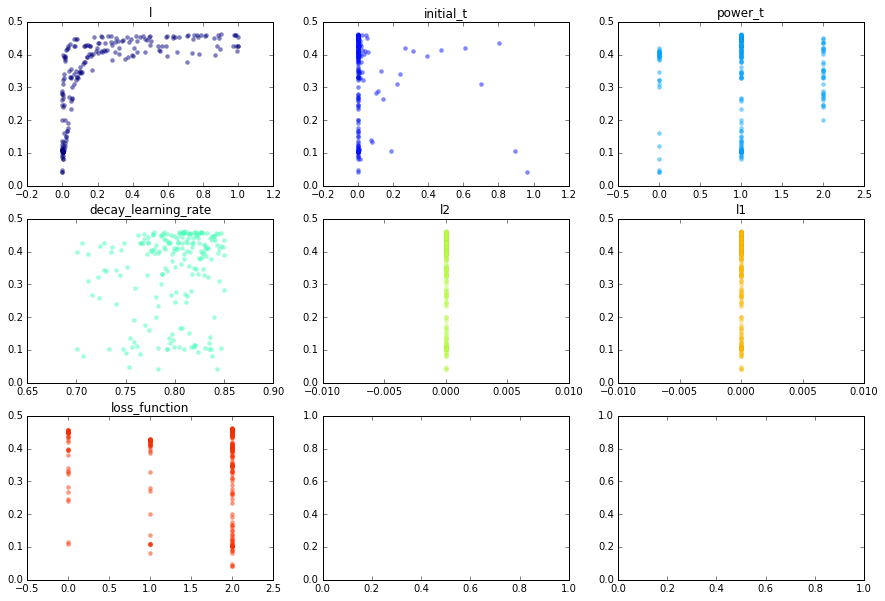

In [448]:
# First run
parameters = ['l', 'initial_t', 'power_t', 'decay_learning_rate', 'l2', 'l1', 'loss_function']
cols = len(parameters)
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    #print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

**shell VW**

In [151]:
%%time

def run_poly(y_valid):
    !vw --oaa=550 -d kaggle_data/train_part_w5.vw --passes=100 \
    -f kaggle_data/initial_model_w5.vw -b 26 --random_seed=7 --cache_file kaggle_data/w5_cache.vw -k \
    --decay_learning_rate 0.8097261737051064 \
    --initial_t 4.617634843743026e-05 -l 0.9037695975303308 --power_t 0.5 --l2=3.022731250666471e-11 \
    --loss_function='logistic' --l1=1.2144958188964683e-11 --cubic="bcd" --sort_features -q "bs" --stage_poly --quiet
    
    !vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
    -p kaggle_data/vw_valid_pred_w5.csv --random_seed=7 --quiet
    
    vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred_w5.csv", header=None)
    accuracy = accuracy_score(y_valid, vw_valid_pred.values)
    
    return accuracy

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [152]:
accuracy = run_poly(y_valid)
print "Accuracy on Poly:", accuracy

Accuracy on Poly: 0.494720405972


In [577]:
%%time
!vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
-p kaggle_data/vw_valid_pred_w5.csv --random_seed=7

creating quadratic features for pairs: bs 
creating cubic features for triples: bcd 
only testing
predictions = kaggle_data/vw_valid_pred_w5.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/valid_w5.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       54      145       17
1.000000 1.000000            2            2.0       97      156       19
1.000000 1.000000            4            4.0      442      189       15
0.875000 0.750000            8            8.0      168      351       15
0.687500 0.500000           16           16.0      508      214       15
0.562500 0.437500           32           32.0      223      223       13
0.562500 0.562500           64           64.0      131      330        9
0.515625 0.468750          128          128.0       34 

In [578]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred_w5.csv", header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.51428518145537283

In [261]:
trainvw = open("kaggle_data/train_w5.vw").readlines()
np.random.shuffle(trainvw)
with open("kaggle_data/train_w5.vw", "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [262]:
%%time
!vw --oaa=550 -d kaggle_data/train_w5.vw --passes=10 \
-f kaggle_data/initial_model_w5.vw -b 26 --random_seed=7 --cache_file kaggle_data/w5_cache.vw -k

final_regressor = kaggle_data/initial_model_w5.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/w5_cache.vw
Reading datafile = kaggle_data/train_w5.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      444        1        9
1.000000 1.000000            2            2.0       18      444        8
1.000000 1.000000            4            4.0      473      444       12
1.000000 1.000000            8            8.0      474      154        6
1.000000 1.000000           16           16.0      115      154        7
1.000000 1.000000           32           32.0      487      273        7
0.984375 0.968750           64           64.0       86      186       11
0.976562 0.968750          128          128.0      311      517       10
0.945312 0.914062     

In [263]:
%%time
!vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
-p kaggle_data/vw_test_pred_w5.csv --random_seed=7 --quiet

CPU times: user 24 ms, sys: 36 ms, total: 60 ms
Wall time: 1.41 s


In [264]:
vw_pred = pd.read_csv("kaggle_data/vw_test_pred_w5.csv", header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)
vw_subm

array([['174'],
       ['783'],
       ['2336'],
       ..., 
       ['1413'],
       ['1771'],
       ['1845']], dtype=object)

**Let's build pemutations of different features and test the model!**

In [229]:
features = ['bot30_portion',
 'day_of_week',
 'daytime',
 'fb_portion',
 'prediction',
 'session_timespan',
 'start_hour',
 'top30_portion', 'youtube_portion']
features

['bot30_portion',
 'day_of_week',
 'daytime',
 'fb_portion',
 'prediction',
 'session_timespan',
 'start_hour',
 'top30_portion',
 'youtube_portion']

In [230]:
%%time

results = {}

for L in range(5, 9):#len(features)+1):
    for subset in itertools.combinations(features, L):      
        keys = list(subset)
        print "Features:", keys

        vw_to_file(train_part_vw["sites"], 'kaggle_data/train_part_w5.vw', features={x:train_part_vw[x] for x in keys})
        vw_to_file(valid_vw["sites"], 'kaggle_data/valid_w5.vw', features={x:valid_vw[x] for x in keys})
        vw_to_file(train_vw["sites"], 'kaggle_data/train_w5.vw', features={x:train_vw[x] for x in keys})
        vw_to_file(test_vw["sites"], 'kaggle_data/test_w5.vw', features={x:test_vw[x] for x in keys})
        
        f = open("kaggle_data/train_part_w5.vw")
        X_train = f.readlines()
        f.close()

        f = open("kaggle_data/valid_w5.vw")
        X_valid = f.readlines()
        f.close()
        
        model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, loss_function='squared')
        cross_scores = cross_val_score(model, X=X_train, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), \
                                                                                                      n_jobs=-1)
        model.fit(X_train)
        accuracy = accuracy_score(y_valid, model.predict(X_valid))
        if np.mean(cross_scores) > 0.45:
            print "POTENTIAL WINNER!"
        print "CV score:", np.mean(cross_scores), "Valid score:", accuracy, "\n"
        results[tuple(keys) or "sites_only"] = {"CV": np.mean(cross_scores), "valid": accuracy}

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'prediction']
CV score: 0.428249403455 Valid score: 0.43513856253 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'session_timespan']
CV score: 0.402299384357 Valid score: 0.414549998135 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'start_hour']
CV score: 0.432272901038 Valid score: 0.443586587595 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'top30_portion']
CV score: 0.401995487292 Valid score: 0.414177016896 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'youtube_portion']
CV score: 0.401379425838 Valid score: 0.41430756033 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'prediction', 'session_timespan']
CV score: 0.429592100559 Valid score: 0.436425347805 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'prediction', 'start_hour']
POTENTIAL WINNER!
CV score: 0.458891248881 Valid score: 0.465760322256 

Featu

In [231]:
sorted(results.items(), key=lambda t: t[1]["CV"], reverse=True)[0:5]

[(('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45998619175968986, 'valid': 0.46714035284025213}),
 (('day_of_week',
   'daytime',
   'fb_portion',
   'prediction',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45990670132196049, 'valid': 0.46576032225579056}),
 (('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45966497130778228, 'valid': 0.46626384692849948}),
 (('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45960830714374462, 'valid': 0.4676438775129611}),
 (('day_of_week',
   'daytime',
   'fb_portion',
   'prediction',
   'start_hour',
   'youtube_portion'),
  {'CV': 0.45947824810382548, 'valid': 0.46618925068069078})]

In [232]:
sorted(results.items(), key=lambda t: t[1]["valid"], reverse=True)[0:5]

[(('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45960830714374462, 'valid': 0.4676438775129611}),
 (('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45998619175968986, 'valid': 0.46714035284025213}),
 (('day_of_week',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45826827578467516, 'valid': 0.46687926597292156}),
 (('bot30_portion',
   'day_of_week',
   'fb_portion',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45858398130710709, 'valid': 0.46671142441535191}),
 (('bot30_portion',
   'day_of_week',
   'fb_portion',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.4577515233046956, 'valid': 0.466618179105591})]